# Wind Field Plot

1. winds used (coarse)
2. Interpolated winds

Develop code to plot wind field. Consider generating a windfield layer

Read NAM DATA and CALPUF data and use Cartopy's vector plots.


In [148]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import axes3d
from matplotlib.font_manager import FontProperties
import os
import datetime as dt
import pytz
import utm
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import netCDF4
from dateutil.parser import parse
import argparse

In [2]:
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return x, y

Follow the same stype as generateMaps.py so that wind field could be output.

In [3]:
date = '20190111' # Most Recent run filled in here
earcemac = '/nfs/earcemac/projects/unresp/ForecastVisualized/UNRESPForecastingSystem'
concDir = earcemac + '/CALPUFF_OUT/CALPUFF/' + date
xyFile = earcemac + '/data/xy_masaya.dat'
outDir = "../plots/wind"

In [4]:
# READ IN X,Y DATA AND CONVERT TO LAT,LON
x, y = Read_Two_Column_File(xyFile)  # read in x,y data
xunq, yunq = np.unique(x), np.unique(y)  # get unique x,y coordinates
nx, ny = len(xunq), len(yunq)  # number of unique x,y coordinates
# Use utm package to convert from x,y to lat,lon...
# ...Nicaragua is UTM zone 16P, and we must convert to metres first:
lat = [utm.to_latlon(x[i] * 1000, y[i] * 1000, 16, 'P')[0]
       for i in np.arange(0, len(x))]
lon = [utm.to_latlon(x[i] * 1000, y[i] * 1000, 16, 'P')[1]
       for i in np.arange(0, len(x))]
# Create gridded field of lat,lon of appropriate size:
glat, glon = np.reshape(lat, (ny, nx)),  np.reshape(lon, (ny, nx))
# Also grab range for static plots
latMin = min(lat)
latMax = max(lat)
lonMin = min(lon)
lonMax = max(lon)
# Get x,y coordinates of all the corners of the square cells centred on
# each x,y (for google plots):
x2unq = [v - (xunq[1] - xunq[0]) / 2. for v in xunq]
x2unq.append(x2unq[-1] + (xunq[1] - xunq[0]))
y2unq = [v - (yunq[1] - yunq[0]) / 2. for v in yunq]
y2unq.append(y2unq[-1] + (yunq[1] - yunq[0]))
nx2, ny2 = len(x2unq), len(y2unq)
x2grd, y2grd = np.meshgrid(x2unq, y2unq)
x2, y2 = np.reshape(x2grd, (nx2 * ny2)), np.reshape(y2grd, (nx2 * ny2))
lat2 = [utm.to_latlon(x2[i] * 1000, y2[i] * 1000, 16, 'P')[0]
        for i in np.arange(0, len(x2))]
lon2 = [utm.to_latlon(x2[i] * 1000, y2[i] * 1000, 16, 'P')[1]
        for i in np.arange(0, len(x2))]
glat2, glon2 = np.reshape(lat2, (ny2, nx2)),  np.reshape(lon2, (ny2, nx2))
#####

## WIND

The CALMET component takes the NAM data (grib) and processes to .dat file

1. Prognostic: Compare .grib and .dat output - dat generated by Create3Ddat.py
2. Diagnostic: Calmet.list lists output looks like printing the wind field is turned off (default)

### Working with GRIB and .dat files

First the easiest solution would be to create netcdf files 

1. GRIB:

    grib2netcdf: ncl_convert2nc
        `ncl_grib2nc *.grib2`
2. .dat 

    * dat to netcdf: [calmet2netcdf](https://www.epa.gov/scram/air-quality-dispersion-modeling-related-model-support-programs#calmet2ncf)
    * all the tools appear to be for windows
    * ECMFW has metview 
    * edit parameters to print winds, might have to just write a python script to plot that data


In [5]:
# Testing version
NAMncdir = '../winddata/20190111/'
ncfile = 'nam.t00z.afwaca00.tm00.nc'
NAMdata=netCDF4.Dataset(NAMncdir+ncfile,'r')

In [226]:
Uvel = NAMdata.variables['UGRD_P0_L100_GLL0'][:,:,:]
Vvel = NAMdata.variables['VGRD_P0_L100_GLL0'][:,:,:]
Wvel=NAMdata.variables['DZDT_P0_L100_GLL0'][:]
P = NAMdata.variables['lv_ISBL0'][:]
lon = NAMdata.variables['lon_0'][:]
lat = NAMdata.variables['lat_0'][:]

In [330]:
x = lon
y = lat
u = np.mean(Uvel[:,:,:], axis=0)
v = np.mean(Vvel[:,:,:], axis=0)
def plot_winds(x, y, u, v):
    color_array = (u**2 + v**2)** 0.5
    request = cimgt.OSM()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    ax1 = axes[0]
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.coastlines('50m')
    ax1.add_image(request, 7)
    ax1.set_extent([x[0],x[-1],y[0],y[-1]], ccrs.PlateCarree())
    p = ax1.quiver(x, y, u, v, color_array, headwidth=4, headlength=4)
    gl = ax1.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.colorbar(p, extend='both', ax=ax1, orientation="horizontal")
    plt.title('WHOLE NAM WIND FIELD', fontsize=18)

    ax2 = axes[1]
    color_array = (u[13:21,12:18]**2 + v[13:21,12:18]**2)** 0.5
    ax2 = plt.figure(1, 2, 2, projection=ccrs.PlateCarree())
    request = cimgt.OSM()
    ax2.add_image(request, 10, interpolation='spline36')
    ax2.coastlines('50m')
    X, Y = np.meshgrid(x, y)
    ax2.set_extent([x[12],x[18],y[13],y[21]], ccrs.PlateCarree())
    q = ax2.quiver(X[13:21,12:18], Y[13:21,12:18], u[13:21,12:18], v[13:21,12:18], color_array, edgecolor='k', pivot='mid', units='inches')
    gl = ax2.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.colorbar(q, extend='both', ax=ax2, orientation="horizontal")
    plt.title('MASAYA NAM WIND FIELD', fontsize=18)
    
def plot_masaya_wind(x, y, u, v):
    
    fig = plt.figure(figsize=(10, 15))
    color_array = (u[13:21,12:18]**2 + v[13:21,12:18]**2)** 0.5
    request = cimgt.OSM()
    ax2 = plt.axes(projection=ccrs.PlateCarree())
    ax2.add_image(request, 10, interpolation='spline36')
    ax2.coastlines('50m')
    X, Y = np.meshgrid(x, y)
    ax2.set_extent([x[12],x[18],y[13],y[21]], ccrs.PlateCarree())
    q = ax2.quiver(X[13:21,12:18], Y[13:21,12:18], u[13:21,12:18], v[13:21,12:18], color_array, edgecolor='k', pivot='mid', units='inches')
    gl = ax2.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    cbar = plt.colorbar(q, extend='both', ax=ax2, orientation="horizontal", label='Wind Speed m/s')
    cbar.ax.tick_params(labelsize=14) 
    plt.title('MASAYA NAM WIND FIELD', fontsize=18)

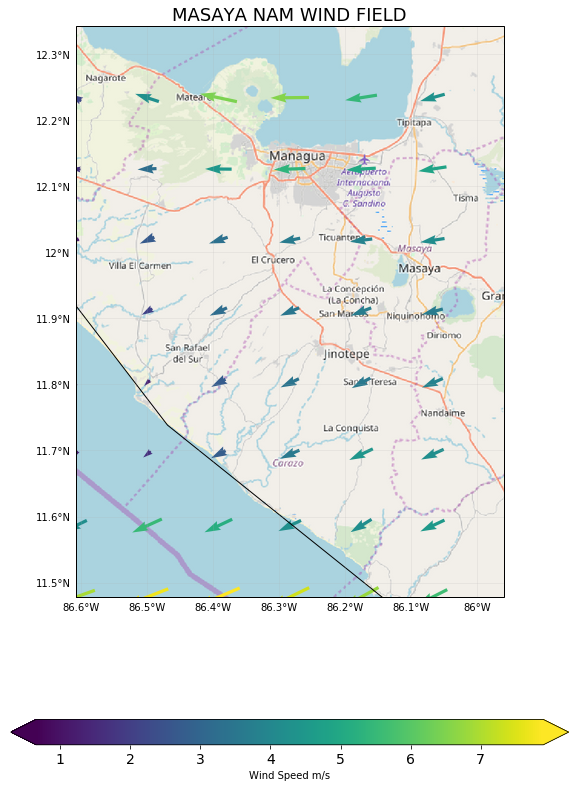

In [331]:
umean = np.mean(Uvel[:,:,:], axis=0)
vmean = np.mean(Vvel[:,:,:], axis=0)
usurf = Uvel[22,:,:]
vsurf = Vvel[22,:,:]
plot_masaya_wind(x, y, usurf, vsurf)